<a href="https://colab.research.google.com/github/fan0307/100-days-of-code/blob/master/%5BMake_a_copy%5D_Scale_AI_2024_Take_Home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tell me X without telling me X
In the era of frontier models, we've grown used to models that have undergone supervised finetunine (SFT) and preference tuning (RLHF/DPO). Want something?  Ask the model.

Today, we're going to humble ourselves and go back in time to an era where these techniques weren't in use. **We'll be using the base GPT-2 model for this assessment**.

**Objective**: Find a different prompt for each keyword below, such that the GPT-2's output contains the keyword as a substring.

**Keywords**: [radagon, godfrey, morgott, marika, radahn]

**Prompt Constraints**
* Prompts must not contain the entire exact keyword
* Prompts must contain <= 10 tokens, as defined by the GPT-2 tokenizer
* GPT-2's greedy decoding output must contain the keyword, within 32 tokens.

In [ ]:
#@title Dependencies
!pip install transformers==4.28.1
import gc
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [ ]:
#@title Load model
def load_model_and_tokenizer(model_path, tokenizer_path=None, device="cuda:0", **kwargs):
    model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=torch.float16,
            trust_remote_code=True,
            **kwargs
        ).to(device).eval()

    tokenizer_path = model_path if tokenizer_path is None else tokenizer_path

    tokenizer = AutoTokenizer.from_pretrained(
        tokenizer_path,
        trust_remote_code=True,
        use_fast=False
    )
    if not tokenizer.pad_token:
        tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

model_path = "gpt2" # do not change
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # avoid cpu, too slow
model, tokenizer = load_model_and_tokenizer(model_path,
                       low_cpu_mem_usage=True,
                       use_cache=False,
                       device=device)

# Test Suite
We've implemented the test suite for you to evaluate whether the constraints are met. Simply provide the prompt.

In [ ]:
MAX_PROMPT_TOKS = 10

keywords = [
    "radagon",
    "godfrey",
    "morgott",
    "marika",
    "radahn",
]

def generate(model, tokenizer, prompt):
    with torch.no_grad():
        gen_config = model.generation_config
        gen_config.max_new_tokens = 32
        input_ids = torch.tensor(tokenizer.encode(prompt))
        input_ids = input_ids.to(model.device).unsqueeze(0)
        attn_masks = torch.ones_like(input_ids).to(model.device)
        output_ids = model.generate(input_ids,
                                    attention_mask=attn_masks,
                                    generation_config=gen_config,
                                    pad_token_id=tokenizer.pad_token_id)[0]
        output_text = tokenizer.decode(output_ids).strip()
        return output_text

def test_case(model, tokenizer, prompt, keyword):
    output = generate(model, tokenizer, prompt)
    error_msg = f'Keyword: {keyword}\nPrompt: {prompt}\nOutput: {output}'
    test_passed = True

    # condition 1: prompt doesn't contain keyword
    if keyword in prompt:
        error_msg += f'\nFail: Keyword "{keyword}" in prompt'
        test_passed = False

    # condition 2: prompt less than MAX_PROMPT_TOKS
    prompt_tok_len = len(tokenizer.encode(prompt))
    if prompt_tok_len > MAX_PROMPT_TOKS:
        error_msg += f'\nFail: Prompt contains {prompt_tok_len} > {MAX_PROMPT_TOKS} tokens'
        test_passed = False

    # condition 3: output must contain keyword
    if keyword not in output:
        error_msg += f'\nFail: Keyword "{keyword}" not in model output'
        test_passed = False

    # all tests passed
    if test_passed:
        return True, error_msg

    return False, error_msg

def run_tests(model, tokenizer, prompts, keywords, verbose):
    successes = 0
    total_tests = len(keywords)

    for keyword in keywords:
        prompt = prompts[keyword]
        test_passed, error_msg = test_case(model, tokenizer, prompt, keyword)
        successes += test_passed
        if verbose:
            print(error_msg)
            print('=' * 20)
    print(f"TESTS PASSED: {successes} of {total_tests}")


# Part 1: Manual Prompt Engineering
Let's try manually prompting GPT-2 to get some intuition.
No deliverable is required for this part.

Good on you if you manage to get one of the keywords generated via manually prompting!

In [ ]:
prompts = {keyword: "your prompt here" for keyword in keywords}
prompts["radagon"] = "try a prompt"

run_tests(model, tokenizer, prompts, keywords, verbose=True)

Keyword: radagon
Prompt: try a prompt
Output: try a prompt to get the name of the file you want to use.

$ curl -s http://localhost:3000/file.json

If you want
Fail: Keyword "radagon" not in model output
Keyword: godfrey
Prompt: your prompt here
Output: your prompt here.

"I'm sorry, but I'm not sure what you're talking about. I'm not sure what you're talking about. I'm not
Fail: Keyword "godfrey" not in model output
Keyword: morgott
Prompt: your prompt here
Output: your prompt here.

"I'm sorry, but I'm not sure what you're talking about. I'm not sure what you're talking about. I'm not
Fail: Keyword "morgott" not in model output
Keyword: marika
Prompt: your prompt here
Output: your prompt here.

"I'm sorry, but I'm not sure what you're talking about. I'm not sure what you're talking about. I'm not
Fail: Keyword "marika" not in model output
Keyword: radahn
Prompt: your prompt here
Output: your prompt here.

"I'm sorry, but I'm not sure what you're talking about. I'm not sure what you'r

# Part 2: Greedy Coordinate Gradient for Automatic Prompting
We will use the Greedy Coordinate Gradient (GCG) algorithm proposed in Zou et al., 2023 (https://arxiv.org/abs/2307.15043) to discover some unintuitive prompts. Formally, we want to optimize for p(target | prompt), where the target is our keyword. You're welcome to add imports and use code from the original authors, we just ask you adapt it to our objective on GPT-2.

On a high level, GCG repeats the following procedure for N iterations:
- 1. [Discrete Grads] For a subset of I prompt tokens to change, take the gradient with respect to each discrete token id as a one-hot vector, attempting to minimize -logp(target | prompt)
- 2. [Filtering] Identify the top-k negative gradients for I tokens, which yields I*k potential token replacements we consider for the next step.
- 3. [Calibrate Loss] Uniformly subsample B potential token replacements from the set of I*k, then compute the loss for each potential replacement: -logp(target | prompt_b)
- 4. [Greedy token replacement] Take the single replacement token with the lowest loss and update the prompt

**You may find the following minimal demo code helpful:** https://github.com/llm-attacks/llm-attacks/blob/main/demo.ipynb
- Important difference: GPT-2 does not use a chat template. We are directly optimizing for a prompt, with generation only conditioning on the prompt and nothing else. Do not add any additional prefixes or suffixes.


**Figure 1**: An example instance of steps 1 & 2, for a single token to change (I=1) with top-k = 1. You will implement a batched procedure with I > 1 and top-k > 1.
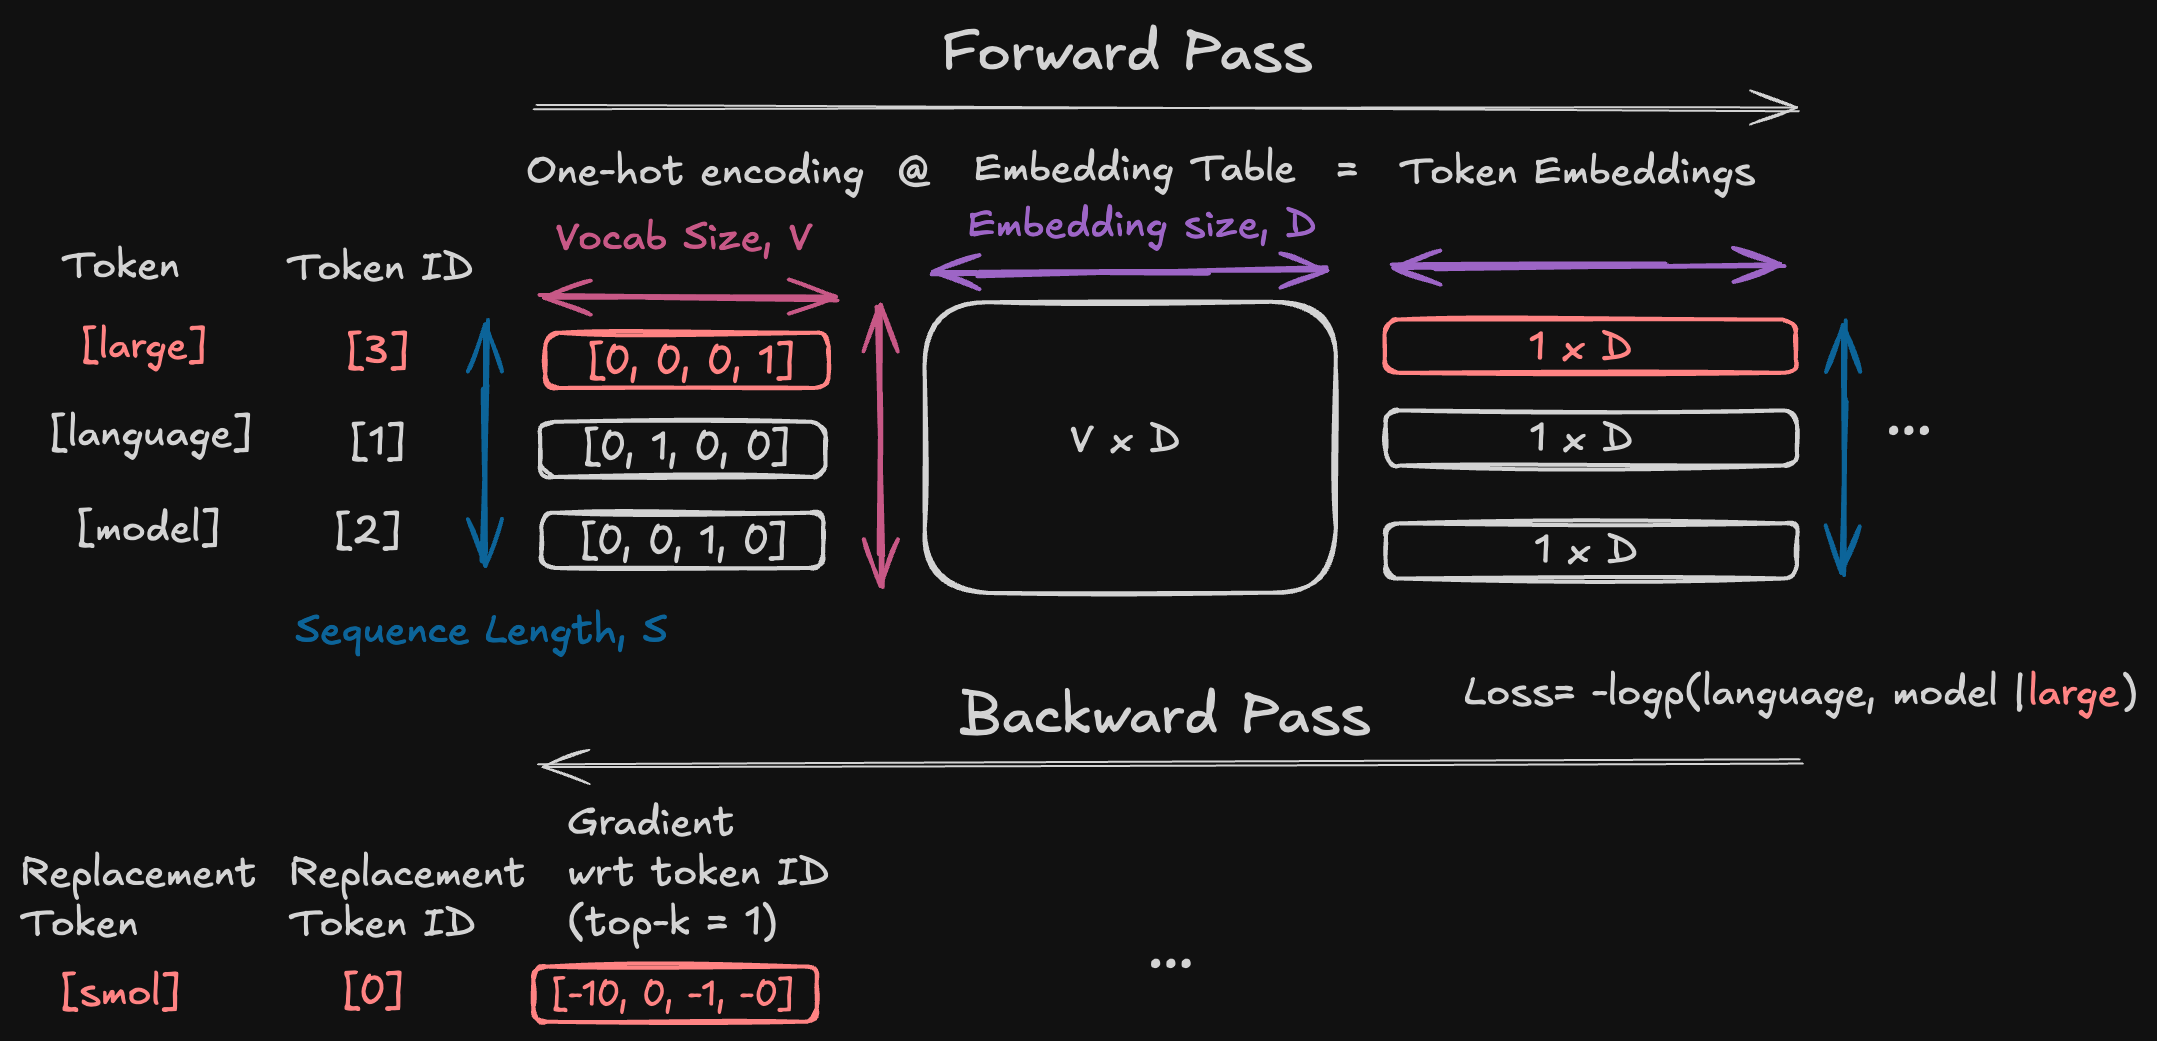


**Deliverable**
1. Find 5 prompts that allow GPT-2's output to contain each of the 5 keywords. Print both your prompts and outputs, and save your colab to display it. This function call will do it for you: `run_tests(model, tokenizer, prompts, keywords, verbose=True)`
2. Provide your code used to generate the prompts below. It's okay if the code is not 100% reproducible due to how GPUs work.

In [ ]:
# optional: use the existing codebase
!git clone https://github.com/llm-attacks/llm-attacks
%cd llm-attacks
!pip install -e .
!pip install livelossplot

In [ ]:
# some initial hparams, feel free to tune
gcg_config = {
    "num_steps": 50,
    "prompt_init": "start" * MAX_PROMPT_TOKS,
    "batch_size": 512,
    "topk": 256,
    "allow_non_ascii": False
}
prompts = {
    "radagon": "your prompt here",
    "godfrey": "your prompt here",
    "morgott": "your prompt here",
    "marika": "your prompt here",
    "radahn": "your prompt here",
}
prompt_found = {keyword: False for keyword in keywords}

In [ ]:
# submit everything printed by this function
# do not add extra print statements, the output format is precise
run_tests(model, tokenizer, prompts, keywords, verbose=True)

**Score certainty:** If you did not modify `run_tests` and copy the output exactly as described into HackerRank, your final score on our backend will be the same as what `run_tests` shows.

# Feedback Survey

Hello! I'm the human who made this assessment. My goal was to make a fun exercise that doesn't take too much time.

After you submit your HackerRank, please take 2 more minutes and let me know how I did. Thank you!

https://forms.gle/8NeRZDAEvB8CRoHT8

**This feedback survey is anonymous, optional, and does not affect your application.**